<a href="https://colab.research.google.com/github/ErickNicolasP/ASE/blob/main/proyecto_ASE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CARGAMOS TODOS LOS DATOS NECESARIOS, BIBLIOTECAS Y ACOMODAMOS LA INFORMACIÓN PARA SU PROXIMA MANIPULACIÓN

In [149]:
#Cargamos el archivo desde google drive
from google.colab import drive
from google.colab import files
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [150]:
#importamos las librerías
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import io as io
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split


In [151]:
#cargamos los data frame en las variables
#2018
dev_2018 = pd.read_csv('/content/gdrive/MyDrive/Ciencia de Datos/ASE/2018/DEV 2018.csv')
#2019
dev_2019 = pd.read_csv('/content/gdrive/MyDrive/Ciencia de Datos/ASE/2019/DEV 2019.csv')
#2020
dev_2020_enero = pd.read_csv('/content/gdrive/MyDrive/Ciencia de Datos/ASE/2020/DEV 2020_enero-marzo.csv')
dev_2020_julio = pd.read_csv('/content/gdrive/MyDrive/Ciencia de Datos/ASE/2020/DEV 2020_julio-septiembre.csv')
dev_2020_octubre = pd.read_csv('/content/gdrive/MyDrive/Ciencia de Datos/ASE/2020/DEV 2020_octubre-diciembre.csv')
#2022
dev_2022_julio = pd.read_csv('/content/gdrive/MyDrive/Ciencia de Datos/ASE/2022/DEV Julio-Septiembre 2022.csv')
dev_2022_octubre = pd.read_csv('/content/gdrive/MyDrive/Ciencia de Datos/ASE/2022/DEV Octubre-Diciembre 2022.csv')

#poblacion 2020, esta se usará de referencia para sacar la tasa_2018, ya que el censo se hace cada 10 años, el más acertado es el de 2020
censo = pd.read_csv('/content/gdrive/MyDrive/Ciencia de Datos/ASE/censo 2020/censo 2020.csv')

<ipython-input-151-fde523059dcc>:3: DtypeWarning: Columns (496,497) have mixed types. Specify dtype option on import or set low_memory=False.
  dev_2018 = pd.read_csv('/content/gdrive/MyDrive/Ciencia de Datos/ASE/2018/DEV 2018.csv')
<ipython-input-151-fde523059dcc>:5: DtypeWarning: Columns (494,496) have mixed types. Specify dtype option on import or set low_memory=False.
  dev_2019 = pd.read_csv('/content/gdrive/MyDrive/Ciencia de Datos/ASE/2019/DEV 2019.csv')


In [152]:
#Los años 2020 y 2022, no tienen los data frame concatenados, por lo que eso se hará acontinuación
#2020
dev_2020 = pd.concat([dev_2020_enero,dev_2020_julio,dev_2020_octubre], axis=0)
#2022
dev_2022 = pd.concat([dev_2022_julio,dev_2022_octubre],axis=0)

#variables de los data frames
#----dev_2018
#----dev_2019
#----dev_2020
#----dev_2022



#EDAD Y EL SEXO CON SU TASA DE MIGRACIÓN. 2018


In [153]:
#Los valores de los devueltos del 2018, toman la edad hasta los 96, pero los valores de 97, 98, 99 son de no especificado, etc.
# por ende estos valores no ayudan a calcular la tasa, también se filtran los valores para solo tomar los hombres y despúes a las mujeres.
# Después se cuentan los valores para contar las personas de cierta edad que han migrado

hombres_df_2018 = dev_2018.loc[(dev_2018["p1"] == 1) & (dev_2018["p2"] < 97), ["p2", "p1"]].value_counts().reset_index()
hombres_df_2018 = hombres_df_2018.loc[:, ["p2", 0]]
hombres_df_2018.columns = ["edad", "contar"]

mujeres_df_2018 = dev_2018.loc[(dev_2018["p1"] == 2) & (dev_2018["p2"] < 97), ["p2", "p1"]].value_counts().reset_index()
mujeres_df_2018 = mujeres_df_2018.loc[:, ["p2", 0]]
mujeres_df_2018.columns = ["edad", "contar"]

In [154]:
#Se toman los valores máximos de las mujeres u hombres, esto es para que los data frames tengan las mismas dimensiones
# se usa el maximo de cualquiera de esos, para asegurar que no se pierden datos
if hombres_df_2018["edad"].max() > mujeres_df_2018["edad"].max() :
    max_2018 = hombres_df_2018["edad"].max()
else:
    max_2018 = mujeres_df_2018["edad"].max()

In [155]:
#Define el rango de edades y las edades presentes en el dataframe hombres_df_2018
rango_edades = set(range(0, max_2018+1))
edades_presentes = set(hombres_df_2018['edad'])
#Encuentra las edades faltantes
edades_faltantes = rango_edades - edades_presentes
#Añade filas para las edades faltantes y establece un valor de 0 para las demás columnas
for edad in edades_faltantes:
    hombres_df_2018.loc[len(hombres_df_2018)] = [edad, 0]
#Ordena el dataframe por edad y reinicia el índice
hombres_df_2018 = hombres_df_2018.sort_values("edad").reset_index(drop=True)

In [156]:
#Define el rango de edades y las edades presentes en el dataframe mujeres_df_2018
rango_edades = set(range(0, max_2018+1))
edades_presentes = set(mujeres_df_2018['edad'])
#Encuentra las edades faltantes
edades_faltantes = rango_edades - edades_presentes
#Añade filas para las edades faltantes y establece un valor de 0 para las demás columnas
for edad in edades_faltantes:
    mujeres_df_2018.loc[len(mujeres_df_2018)] = [edad, 0]
#Ordena el dataframe por edad y reinicia el índice
mujeres_df_2018 = mujeres_df_2018.sort_values("edad").reset_index(drop=True)

In [157]:
censo_2018 = censo
tasa_2018 = pd.DataFrame(columns=['hombres', 'mujeres'])
censo_2018 = censo_2018.replace(',', '', regex=True).astype('int64')
censo_2018 = censo_2018.iloc[0:max_2018+1]

In [158]:
tasa_2018["hombres"] = (hombres_df_2018["contar"]/censo_2018["Hombres"])*1000
tasa_2018["mujeres"] = (mujeres_df_2018["contar"]/censo_2018["Mujeres"])*1000
tasa_2018 = pd.concat([tasa_2018, hombres_df_2018["edad"]], axis=1)

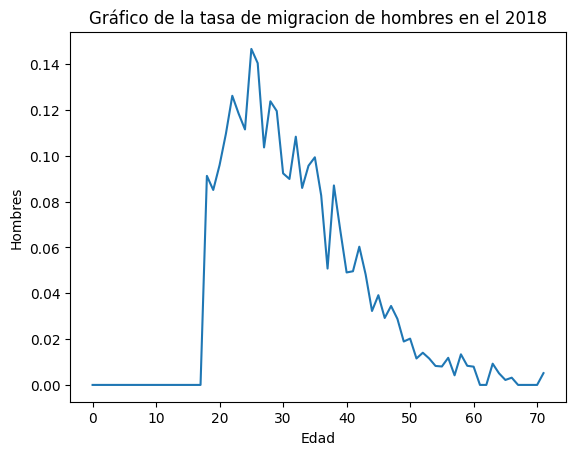

In [159]:
plt.plot(hombres_df_2018['edad'], tasa_2018['hombres'])
plt.xlabel('Edad')
plt.ylabel('Hombres')
plt.title('Gráfico de la tasa de migracion de hombres en el 2018')
plt.show()

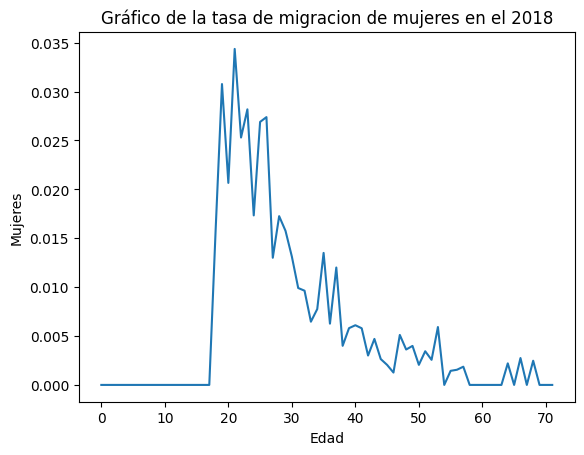

In [160]:
plt.plot(hombres_df_2018['edad'], tasa_2018['mujeres'])
plt.xlabel('Edad')
plt.ylabel('Mujeres')
plt.title('Gráfico de la tasa de migracion de mujeres en el 2018')
plt.show()

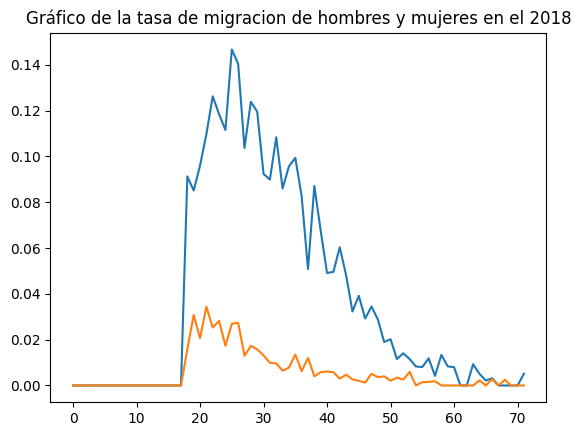

In [161]:
plt.plot(hombres_df_2018['edad'], tasa_2018['hombres'])
plt.plot(hombres_df_2018['edad'], tasa_2018['mujeres'])
plt.title('Gráfico de la tasa de migracion de hombres y mujeres en el 2018')
plt.show()

In [162]:
scaler = MinMaxScaler()
tasa_norm_2018 = scaler.fit_transform(tasa_2018)
tasa_norm_2018 = pd.DataFrame(tasa_norm_2018, columns=tasa_2018.columns)

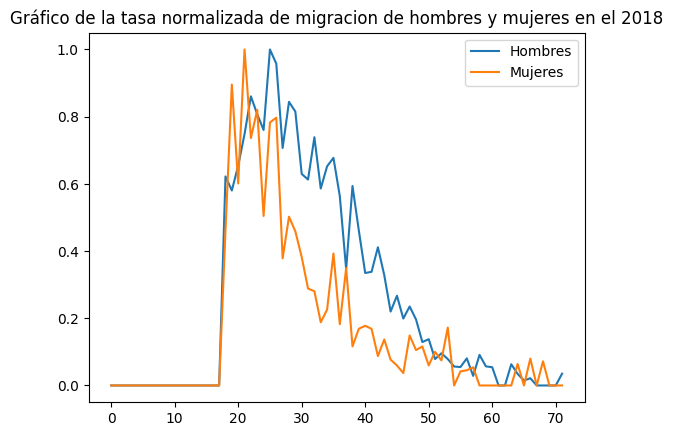

In [163]:
plt.plot(hombres_df_2018['edad'], tasa_norm_2018['hombres'],label="Hombres")
plt.plot(hombres_df_2018['edad'], tasa_norm_2018['mujeres'],label="Mujeres")
plt.title('Gráfico de la tasa normalizada de migracion de hombres y mujeres en el 2018')
plt.legend()
plt.show()

# EDAD Y SEXO CON SU TASA DE MIGRACIÓN. 2019

In [164]:
hombres_df_2019 = dev_2019.loc[(dev_2019["p1"] == 1) & (dev_2019["p2"] < 97), ["p2", "p1"]].value_counts().reset_index()
hombres_df_2019 = hombres_df_2019.loc[:, ["p2", 0]]
hombres_df_2019.columns = ["edad", "contar"]

mujeres_df_2019 = dev_2019.loc[(dev_2019["p1"] == 2) & (dev_2019["p2"] < 97), ["p2", "p1"]].value_counts().reset_index()
mujeres_df_2019 = mujeres_df_2019.loc[:, ["p2", 0]]
mujeres_df_2019.columns = ["edad", "contar"]

In [165]:
if hombres_df_2019["edad"].max() > mujeres_df_2019["edad"].max() :
    max_2019 = hombres_df_2019["edad"].max()
else:
    max_2019 = mujeres_df_2019["edad"].max()

In [166]:
rango_edades = set(range(0, max_2019+1))
edades_presentes = set(hombres_df_2019['edad'])
edades_faltantes = rango_edades - edades_presentes

for edad in edades_faltantes:
    hombres_df_2019.loc[len(hombres_df_2019)] = [edad, 0]
hombres_df_2019 = hombres_df_2019.sort_values("edad").reset_index(drop=True)

In [167]:
rango_edades = set(range(0, max_2019+1))
edades_presentes = set(mujeres_df_2019['edad'])
edades_faltantes = rango_edades - edades_presentes

for edad in edades_faltantes:
    mujeres_df_2019.loc[len(mujeres_df_2019)] = [edad, 0]
mujeres_df_2019 = mujeres_df_2019.sort_values("edad").reset_index(drop=True)

In [168]:
censo_2019 = censo
tasa_2019 = pd.DataFrame(columns=['hombres', 'mujeres'])
censo_2019 = censo_2019.replace(',', '', regex=True).astype('int64')
censo_2019 = censo_2019.iloc[0:max_2019+1]

In [169]:
tasa_2019["hombres"] = (hombres_df_2019["contar"]/censo_2019["Hombres"])*1000
tasa_2019["mujeres"] = (mujeres_df_2019["contar"]/censo_2019["Mujeres"])*1000
tasa_2019 = pd.concat([tasa_2019, hombres_df_2019["edad"]], axis=1)

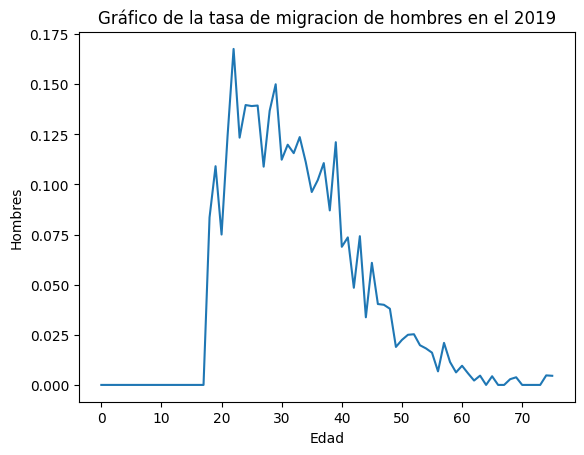

In [170]:
plt.plot(hombres_df_2019['edad'], tasa_2019['hombres'])
plt.xlabel('Edad')
plt.ylabel('Hombres')
plt.title('Gráfico de la tasa de migracion de hombres en el 2019')
plt.show()

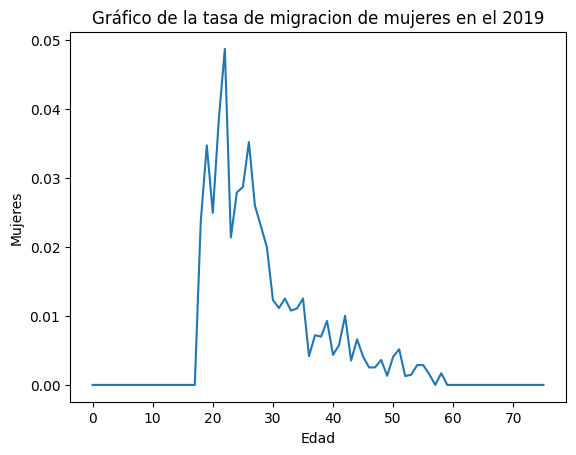

In [171]:
plt.plot(hombres_df_2019['edad'], tasa_2019['mujeres'])
plt.xlabel('Edad')
plt.ylabel('Mujeres')
plt.title('Gráfico de la tasa de migracion de mujeres en el 2019')
plt.show()

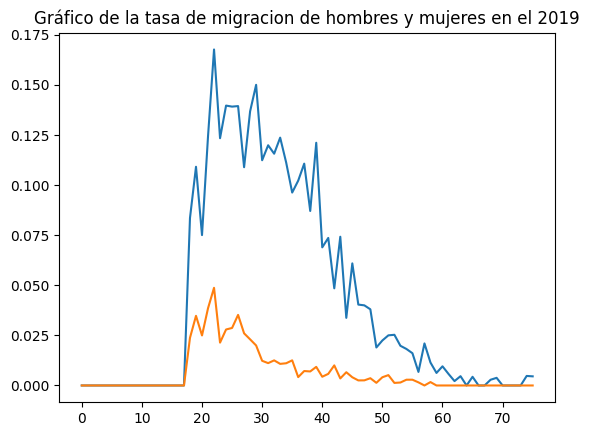

In [172]:
plt.plot(hombres_df_2019['edad'], tasa_2019['hombres'])
plt.plot(hombres_df_2019['edad'], tasa_2019['mujeres'])
plt.title('Gráfico de la tasa de migracion de hombres y mujeres en el 2019')
plt.show()

In [173]:
scaler = MinMaxScaler()
tasa_norm_2019 = scaler.fit_transform(tasa_2019)
tasa_norm_2019 = pd.DataFrame(tasa_norm_2019, columns=tasa_2019.columns)

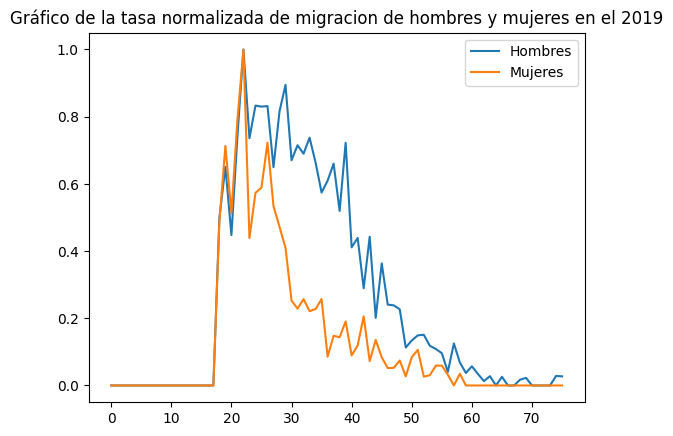

In [174]:
plt.plot(hombres_df_2019['edad'], tasa_norm_2019['hombres'],label="Hombres")
plt.plot(hombres_df_2019['edad'], tasa_norm_2019['mujeres'],label="Mujeres")
plt.title('Gráfico de la tasa normalizada de migracion de hombres y mujeres en el 2019')
plt.legend()
plt.show()

#EDAD Y SEXO CON SU TASA DE MIGRACIÓN. 2020

In [175]:
hombres_df_2020 = dev_2020.loc[(dev_2020["a1"] == 1) & (dev_2020["a2"] < 97), ["a2", "a1"]].value_counts().reset_index()
hombres_df_2020 = hombres_df_2020.loc[:, ["a2", 0]]
hombres_df_2020.columns = ["edad", "contar"]

mujeres_df_2020 = dev_2020.loc[(dev_2020["a1"] == 2) & (dev_2020["a2"] < 97), ["a2", "a1"]].value_counts().reset_index()
mujeres_df_2020 = mujeres_df_2020.loc[:, ["a2", 0]]
mujeres_df_2020.columns = ["edad", "contar"]

In [176]:
if hombres_df_2020["edad"].max() > mujeres_df_2020["edad"].max() :
    max_2020 = hombres_df_2020["edad"].max()
else:
    max_2020 = mujeres_df_2020["edad"].max()

In [177]:
rango_edades = set(range(0, max_2020+1))
edades_presentes = set(hombres_df_2020['edad'])
edades_faltantes = rango_edades - edades_presentes

for edad in edades_faltantes:
    hombres_df_2020.loc[len(hombres_df_2020)] = [edad, 0]
hombres_df_2020 = hombres_df_2020.sort_values("edad").reset_index(drop=True)

In [178]:
rango_edades = set(range(0, max_2020+1))
edades_presentes = set(mujeres_df_2020['edad'])
edades_faltantes = rango_edades - edades_presentes

for edad in edades_faltantes:
    mujeres_df_2020.loc[len(mujeres_df_2020)] = [edad, 0]
mujeres_df_2020 = mujeres_df_2020.sort_values("edad").reset_index(drop=True)

In [179]:
censo_2020 = censo
tasa_2020 = pd.DataFrame(columns=['hombres', 'mujeres'])
censo_2020 = censo_2020.replace(',', '', regex=True).astype('int64')
censo_2020 = censo_2020.iloc[0:max_2020+1]

In [180]:
tasa_2020["hombres"] = (hombres_df_2020["contar"]/censo_2020["Hombres"])*1000
tasa_2020["mujeres"] = (mujeres_df_2020["contar"]/censo_2020["Mujeres"])*1000
tasa_2020 = pd.concat([tasa_2020, hombres_df_2020["edad"]], axis=1)

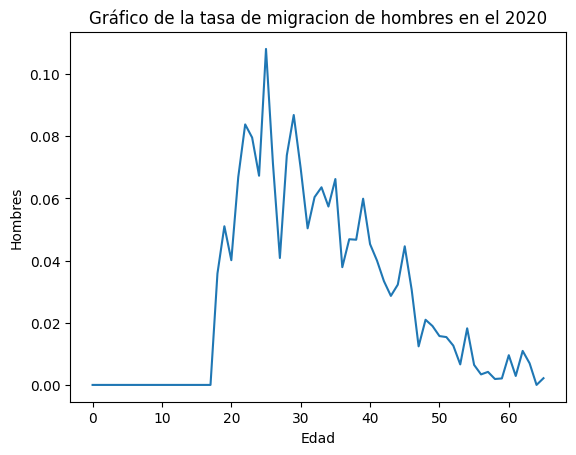

In [181]:
plt.plot(hombres_df_2020['edad'], tasa_2020['hombres'])
plt.xlabel('Edad')
plt.ylabel('Hombres')
plt.title('Gráfico de la tasa de migracion de hombres en el 2020')
plt.show()

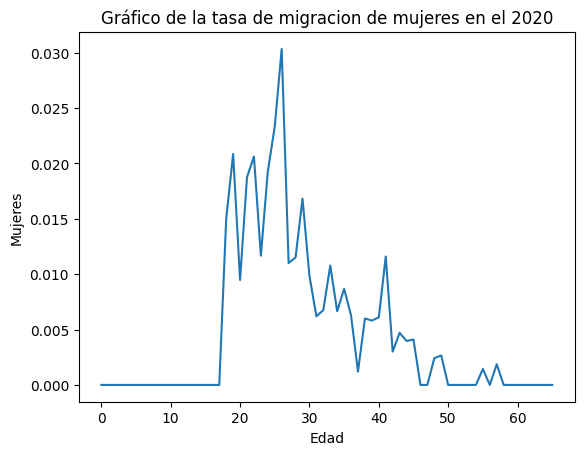

In [182]:
plt.plot(hombres_df_2020['edad'], tasa_2020['mujeres'])
plt.xlabel('Edad')
plt.ylabel('Mujeres')
plt.title('Gráfico de la tasa de migracion de mujeres en el 2020')
plt.show()

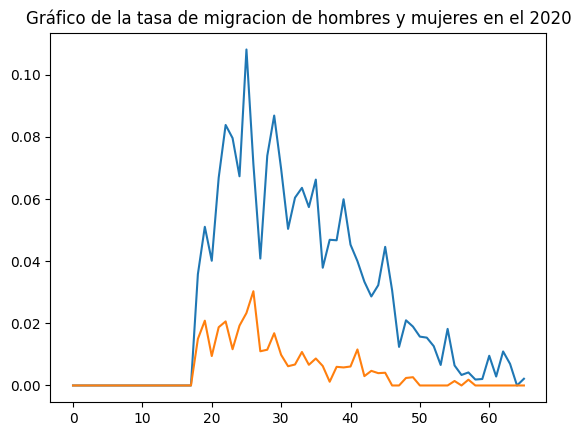

In [183]:
plt.plot(hombres_df_2020['edad'], tasa_2020['hombres'])
plt.plot(hombres_df_2020['edad'], tasa_2020['mujeres'])
plt.title('Gráfico de la tasa de migracion de hombres y mujeres en el 2020')
plt.show()

In [184]:
scaler = MinMaxScaler()
tasa_norm_2020 = scaler.fit_transform(tasa_2020)
tasa_norm_2020 = pd.DataFrame(tasa_norm_2020, columns=tasa_2020.columns)

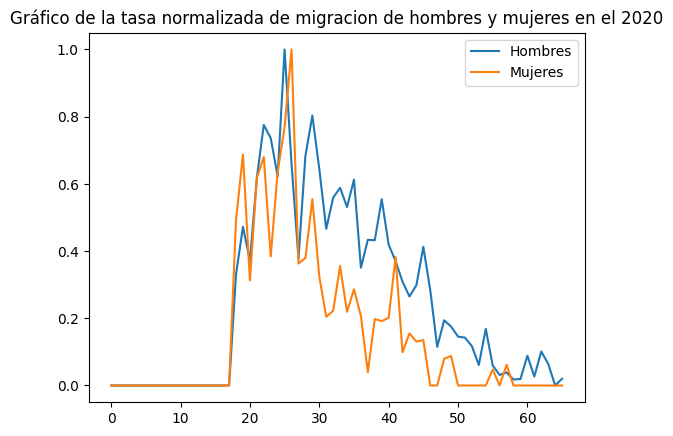

In [185]:
plt.plot(hombres_df_2020['edad'], tasa_norm_2020['hombres'],label="Hombres")
plt.plot(hombres_df_2020['edad'], tasa_norm_2020['mujeres'],label="Mujeres")
plt.title('Gráfico de la tasa normalizada de migracion de hombres y mujeres en el 2020')
plt.legend()
plt.show()

#EDAD Y SEXO CON SU TASA DE MIGRACIÓN 2022



In [186]:
hombres_df_2022 = dev_2022.loc[(dev_2022["a1"] == 1) & (dev_2022["a2"] < 97), ["a2", "a1"]].value_counts().reset_index()
hombres_df_2022 = hombres_df_2022.loc[:, ["a2", 0]]
hombres_df_2022.columns = ["edad", "contar"]

mujeres_df_2022 = dev_2022.loc[(dev_2022["a1"] == 2) & (dev_2022["a2"] < 97), ["a2", "a1"]].value_counts().reset_index()
mujeres_df_2022 = mujeres_df_2022.loc[:, ["a2", 0]]
mujeres_df_2022.columns = ["edad", "contar"]

In [187]:
if hombres_df_2022["edad"].max() > mujeres_df_2022["edad"].max() :
    max_2022 = hombres_df_2022["edad"].max()
else:
    max_2022 = mujeres_df_2022["edad"].max()

In [188]:
rango_edades = set(range(0, max_2022+1))
edades_presentes = set(hombres_df_2022['edad'])
edades_faltantes = rango_edades - edades_presentes

for edad in edades_faltantes:
    hombres_df_2022.loc[len(hombres_df_2022)] = [edad, 0]
hombres_df_2022 = hombres_df_2022.sort_values("edad").reset_index(drop=True)

In [189]:
rango_edades = set(range(0, max_2022+1))
edades_presentes = set(mujeres_df_2022['edad'])
edades_faltantes = rango_edades - edades_presentes

for edad in edades_faltantes:
    mujeres_df_2022.loc[len(mujeres_df_2022)] = [edad, 0]
mujeres_df_2022 = mujeres_df_2022.sort_values("edad").reset_index(drop=True)

In [190]:
censo_2022 = censo
tasa_2022 = pd.DataFrame(columns=['hombres', 'mujeres'])
censo_2022 = censo_2022.replace(',', '', regex=True).astype('int64')
censo_2022 = censo_2022.iloc[0:max_2022+1]

In [191]:
tasa_2022["hombres"] = (hombres_df_2022["contar"]/censo_2022["Hombres"])*1000
tasa_2022["mujeres"] = (mujeres_df_2022["contar"]/censo_2022["Mujeres"])*1000
tasa_2022 = pd.concat([tasa_2022, hombres_df_2022["edad"]], axis=1)

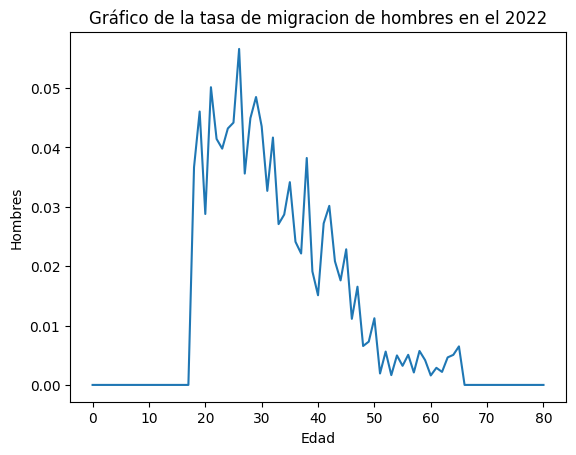

In [192]:
plt.plot(hombres_df_2022['edad'], tasa_2022['hombres'])
plt.xlabel('Edad')
plt.ylabel('Hombres')
plt.title('Gráfico de la tasa de migracion de hombres en el 2022')
plt.show()

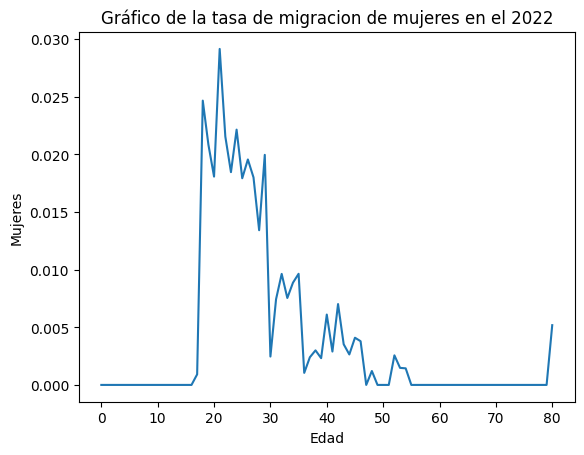

In [193]:
plt.plot(hombres_df_2022['edad'], tasa_2022['mujeres'])
plt.xlabel('Edad')
plt.ylabel('Mujeres')
plt.title('Gráfico de la tasa de migracion de mujeres en el 2022')
plt.show()

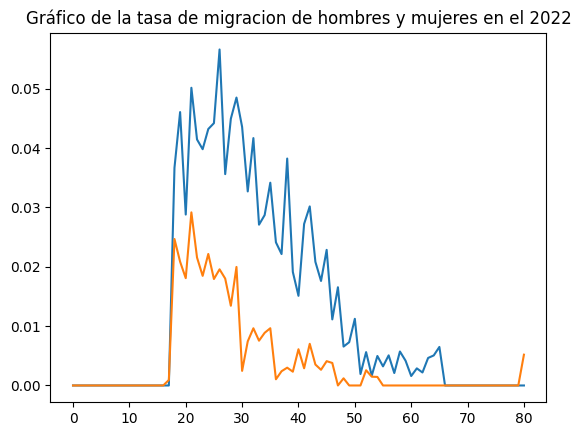

In [194]:
plt.plot(hombres_df_2022['edad'], tasa_2022['hombres'])
plt.plot(hombres_df_2022['edad'], tasa_2022['mujeres'])
plt.title('Gráfico de la tasa de migracion de hombres y mujeres en el 2022')
plt.show()

In [195]:
scaler = MinMaxScaler()
tasa_norm_2022 = scaler.fit_transform(tasa_2022)
tasa_norm_2022 = pd.DataFrame(tasa_norm_2022, columns=tasa_2022.columns)

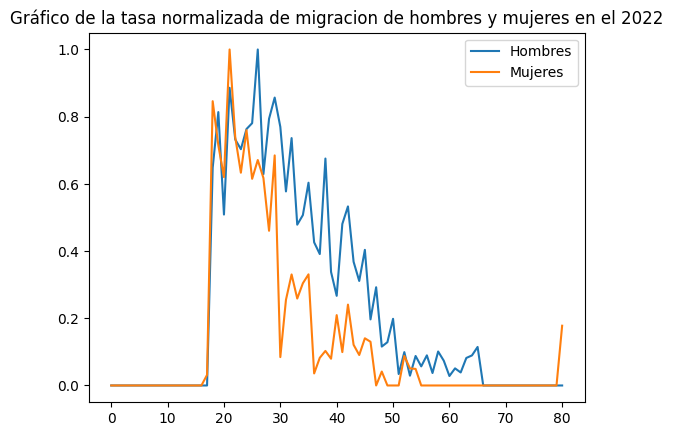

In [196]:
plt.plot(hombres_df_2022['edad'], tasa_norm_2022['hombres'],label="Hombres")
plt.plot(hombres_df_2022['edad'], tasa_norm_2022['mujeres'],label="Mujeres")
plt.title('Gráfico de la tasa normalizada de migracion de hombres y mujeres en el 2022')
plt.legend()
plt.show()

# PREDECIMOS LAS TASAS POST-PANDEMIA

In [197]:
df_melted = pd.melt(tasa_2018, id_vars=['edad'], var_name="sexo", value_name="tasa_migracion")
df_melted

,edad,sexo,tasa_migracion
0,0,hombres,0.000000
1,1,hombres,0.000000
2,2,hombres,0.000000
3,3,hombres,0.000000
4,4,hombres,0.000000
...,...,...,...
139,67,mujeres,0.000000
140,68,mujeres,0.002474
141,69,mujeres,0.000000
142,70,mujeres,0.000000


In [198]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Carga de datos históricos de migración
datos = pd.read_csv('datos_migracion.csv')

FileNotFoundError: ignored

In [ ]:
# Separación en conjunto de entrenamiento y prueba
X_entrenamiento = datos[['tasa_migracion', 'edad', 'sexo']]
y_entrenamiento = datos['cantidad_migrantes']
X_prueba = datos_nuevos[['tasa_migracion', 'edad', 'sexo']]

In [ ]:
# Ajuste de modelo de regresión lineal
modelo = LinearRegression().fit(X_entrenamiento, y_entrenamiento)

# Predicción de cantidad de migrantes para el siguiente año
cantidad_migrantes_prediccion = modelo.predict(X_prueba)